<Axes: xlabel='Date'>

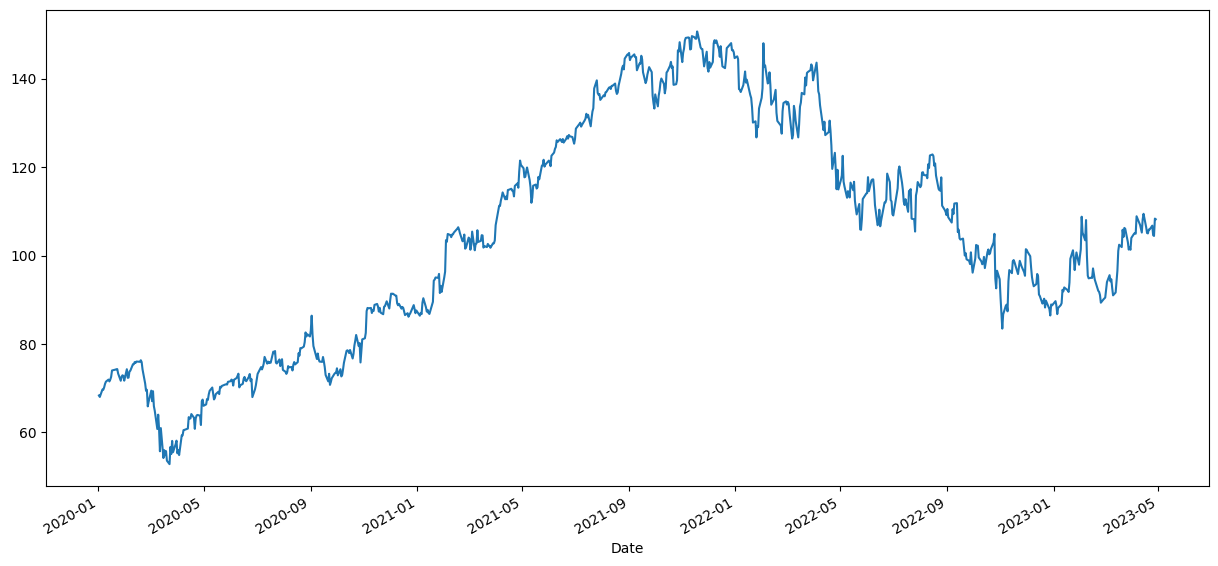

In [1]:
import yfinance as yf
from matplotlib import pyplot as plt
import pandas as pd

# ticker_symbol = 'GOOG'
# data = yf.download(ticker_symbol, start='2010-01-01', end='2024-01-01')

# data = pd.read_csv('../data/GOOG.csv', index_col='Date', parse_dates=True)
start = "2020-01-01"
test_start = "2023-05-01"
interval = "1d"
goog = yf.Ticker('GOOG')

data = goog.history(start=start, interval=interval, end=test_start)
data = data.dropna()

# # train test split
# df = data[['Close']][:'2022']
# df_test = data[['Close']]['2022':]


df = data[['Close']]
df['Close'].plot(figsize=(15, 7))


In [2]:
from statsmodels.tsa.stattools import adfuller

adf_res = adfuller(df['Close'], autolag = 'AIC')
print('p-Values:' + str(adf_res[1]))

p-Values:0.49381783345980246


p-Values:0.0


C:\Users\napat\AppData\Local\Temp\ipykernel_3996\1849440833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close_diff'] = df['Close'].diff(1)


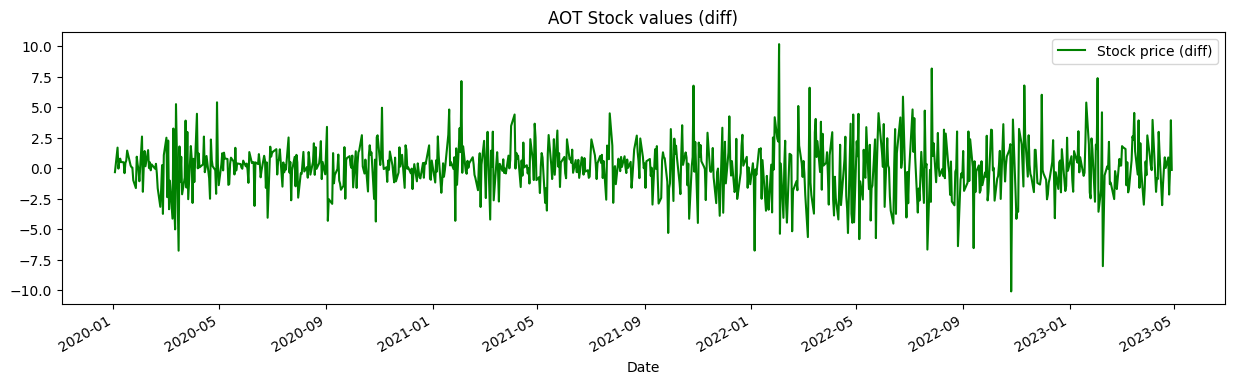

In [3]:
df['Close_diff'] = df['Close'].diff(1)
df['Close_diff'].plot(color = 'green', figsize = (15,4))
plt.legend(['Stock price (diff)'])
plt.title('AOT Stock values (diff)')

adf_res = adfuller(df['Close_diff'].dropna(), autolag = 'AIC')
print('p-Values:' + str(adf_res[1]))

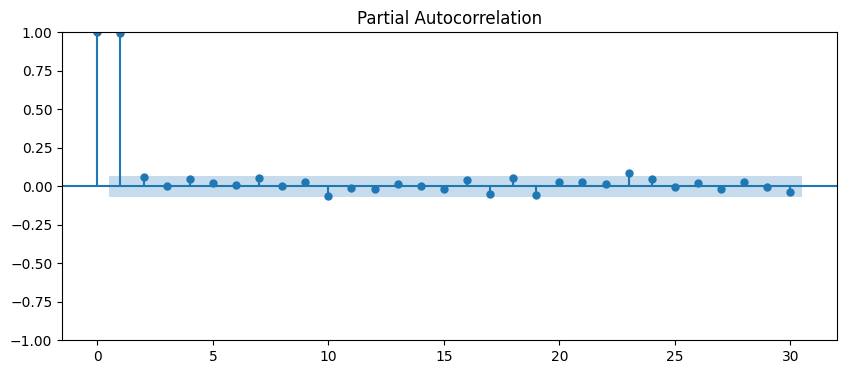

In [4]:
from statsmodels.graphics.tsaplots import  plot_pacf
from statsmodels.tsa.stattools import pacf

plt.rcParams.update({'figure.figsize':(10,4)})
plot_pacf(df['Close'].dropna(), method = 'ols')
df_pacf = pacf(df['Close'].dropna(), method = 'ols')

In [5]:
import numpy as np

for i in range(0, len(df_pacf)):
    if df_pacf[i] < 1.96 / np.sqrt(len(df['Close'])):
        print('p =',i - 1)
        break

p = 1


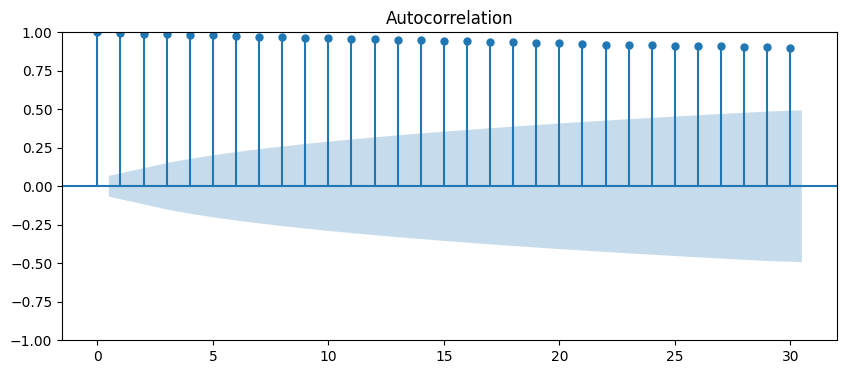

In [6]:

#Moving Average (q)
from statsmodels.graphics.tsaplots import  plot_acf
from statsmodels.tsa.stattools import acf

plt.rcParams.update({'figure.figsize':(10,4)})
plot_acf(df['Close'], fft = True)
df_acf = acf(df['Close'], fft = True)

In [7]:
for i in range(0, len(df_acf)):
    if df_acf[i] < 1.96 / np.sqrt(len(df['Close'])):
        print('q=', i - 1)
        break

In [19]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
p = q = [7, 2]
d = [1] 
pdq = list(itertools.product(p, d, q))

aic = []

for param in pdq:
    try:
        model = ARIMA(df['Close'].dropna(), order = param)
        results = model.fit()
        a = (results.aic, param)
        aic.append(a)
    except:
        continue
aic

c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

[(3660.888535858743, (7, 1, 7)),
 (3666.170701430434, (7, 1, 2)),
 (3666.9716442904455, (2, 1, 7)),
 (3659.7978657011263, (2, 1, 2))]

In [21]:
min_order = min(aic)[1]
print('Min AIC:', min(aic))

# aic is (value, (p, d, q))
# p is AR, q is MA, r is difference

# AR is the number of lags of Y to be used as predictors.
# what is number of lags meaning? how many previous values of Y are used to predict the current value of Y
# which mean next stock price is depend on previous stock price 
# what if p is 0? it means that the current value of Y is not dependent on the previous values of Y

# q is the number of lagged forecast errors that should go into the ARIMA model
# what is the meaning of q? how many previous forecast errors are used to predict the current value of Y
# which mean the next stock price is depend on previous forecast errors
# what if q is 0? it means that the current value of Y is not dependent on the previous forecast errors

# d is the number of differencing required to make the time series stationary
# what is the meaning of d? how many times the raw observations are differenced to make the time series stationary
# what if d is 0? it means that the time series is already stationary

# what if q is 0 and p is 0? it means that the current value of Y is not dependent on the previous values of Y and previous forecast errors
# what current y depend on if q and p is 0? ans: random walk (equation: Y(t) = c + e(t))

# what is e(t)? ans: error term at time t
# how we know e(t)? ans: we can't know e(t) because it is random
# which mean e(t) is random variable
# what is c? ans: constant term

# arima 1 1 1 equation: Y(t) = c + Y(t-1) + e(t-1) + e(t)


Min AIC: (3659.7978657011263, (2, 1, 2))


In [22]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
import torch
def MASE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean(torch.abs(pred - y) / torch.mean(torch.abs(y[1:] - y[:-1]))))

def SMAPE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(200 * torch.mean(torch.abs(pred - y) / (torch.abs(y) + torch.abs(pred))))

def MAE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean(torch.abs(pred - y)))

def sharp_ratio(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean((pred - y) / torch.std(y)))

c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                  837
Model:               ARIMA(30, 1, 30)   Log Likelihood               -1795.814
Date:                Fri, 10 May 2024   AIC                           3713.627
Time:                        01:27:32   BIC                           4002.073
Sample:                             0   HQIC                          3824.204
                                - 837                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9555      0.698     -1.368      0.171      -2.324       0.413
ar.L2         -0.7241      0.568     -1.276      0.202      -1.837       0.388
ar.L3         -0.4575      0.380     -1.203      0.2

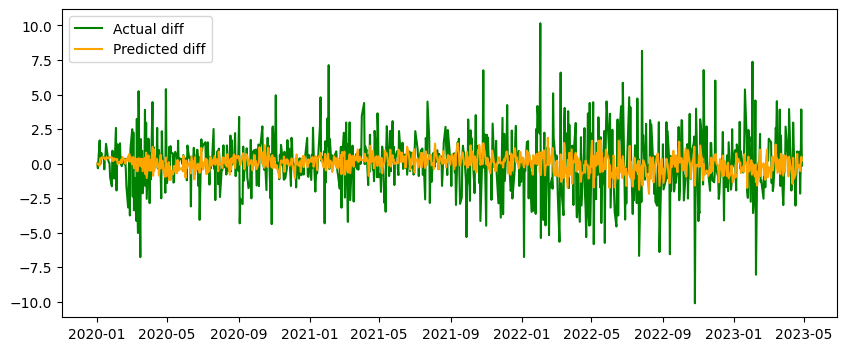

In [26]:
model = ARIMA(df['Close_diff'], order = (30,1,30))#min_order)
results = model.fit()
print(results.summary())

#Prediction
plt.figsize = (15,4)
plt.plot(df['Close_diff'], color = 'green', label = 'Actual diff')
plt.plot(results.predict(), color= 'orange', label = 'Predicted diff')
plt.legend()

In [27]:
# print mse
from sklearn.metrics import mean_squared_error
df['Close_diff'].fillna(0, inplace = True)
print('MSE:', mean_squared_error(df['Close_diff'], results.predict()))

MSE: 4.267330119241817


C:\Users\napat\AppData\Local\Temp\ipykernel_3996\3559543743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close_diff'].fillna(0, inplace = True)


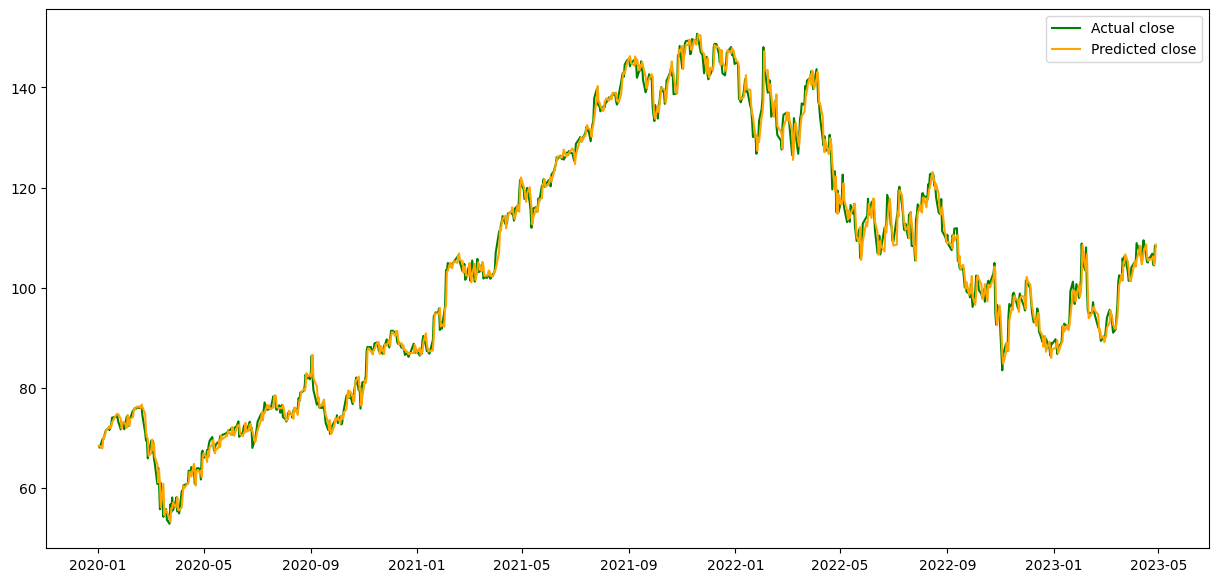

In [28]:
import pandas as pd

prediction = pd.DataFrame(columns=['Predicted'])
prediction['Predicted'] = results.predict()
# print(prediction)
df_pred = pd.merge(df, prediction, how = 'left', left_index = True, right_index = True)

df_pred['Predicted_close'] = df_pred['Close'] + df_pred['Predicted'].shift(-1)
df_pred['Predicted_close'] = df_pred['Predicted_close'].shift(1).fillna(df['Close'])
plt.figure(figsize=(15, 7))
plt.plot(df_pred['Close'], color = 'green', label = 'Actual close')
plt.plot(df_pred['Predicted_close'], color='orange', label = 'Predicted close')
plt.legend()


In [14]:
print("error on train data")
print('MSE:', mean_squared_error(df['Close'], df_pred['Predicted_close']))
print('MASE:', MASE(df_pred['Predicted_close'], df['Close']))
print('SMAPE:', SMAPE(df_pred['Predicted_close'], df['Close']))
print('MAE:', MAE(df_pred['Predicted_close'], df['Close']))
print('Sharp ratio:', sharp_ratio(df_pred['Predicted_close'], df['Close']))

error on train data
MSE: 4.536326291734396
MASE: 0.9895944340725397
SMAPE: 1.5387107315762762
MAE: 1.5453498244965362
Sharp ratio: 0.0004109277839505555


C:\Users\napat\AppData\Local\Temp\ipykernel_3996\1950105554.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = torch.tensor(pred)
C:\Users\napat\AppData\Local\Temp\ipykernel_3996\1950105554.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(y)
C:\Users\napat\AppData\Local\Temp\ipykernel_3996\1950105554.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = torch.tensor(pred)
C:\Users\napat\AppData\Loca

<Axes: xlabel='Date'>

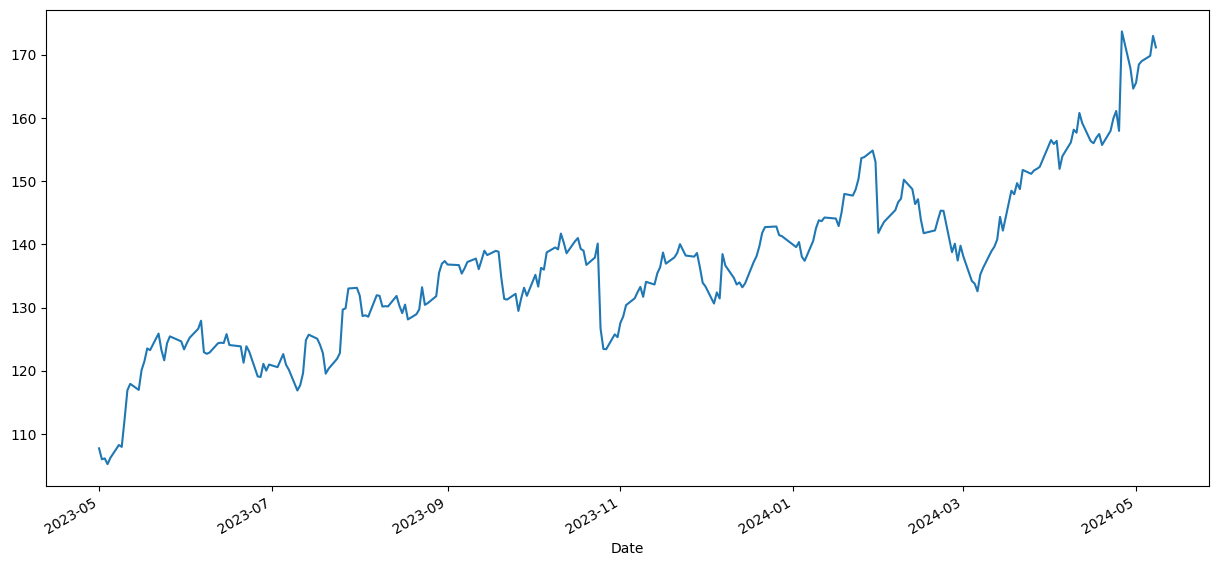

In [15]:
#prediction

data_test = goog.history(start=test_start, interval=interval)
data_test = data_test.dropna()
df_test = data_test[['Close']]
df_test['Close'].plot(figsize=(15, 7))


      Predicted
837   -0.123671
838   -0.201944
839    0.365365
840   -0.403567
841    0.326253
...         ...
1090   0.135765
1091  -0.105895
1092   0.104802
1093  -0.024256
1094  -0.011359

[258 rows x 1 columns]


c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


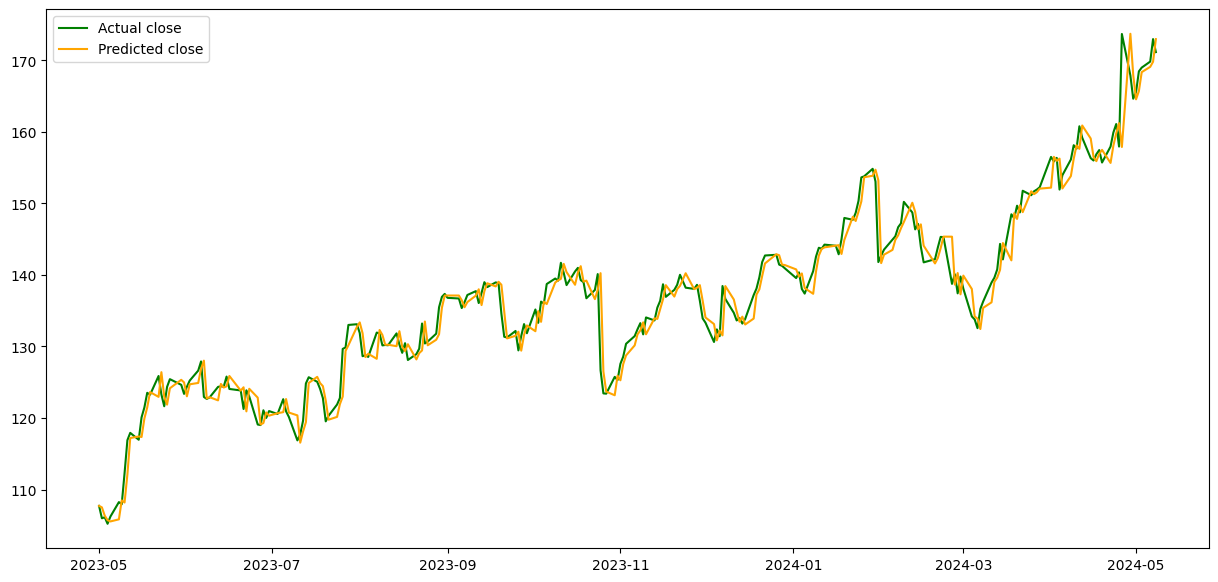

In [16]:
# prediction by arima without seen the future
prediction = pd.DataFrame(columns=['Predicted'])
print()
df_all = pd.concat([df, df_test])
prediction['Predicted'] = results.predict(start = len(df), end = len(df_all) - 1)

print(prediction)

df_test_pred = df_test["Close"].copy()
df_test_pred = df_test_pred.reset_index()
df_test_pred["Predicted"] = prediction["Predicted"].values
df_test_pred.set_index("Date", inplace=True)

df_test_pred['Predicted_close'] = df_test_pred['Close'] + df_test_pred['Predicted'].shift(-1)
df_test_pred['Predicted_close'] = df_test_pred['Predicted_close'].shift(1).fillna(df_test['Close'])
plt.figure(figsize=(15, 7))
plt.plot(df_test_pred['Close'], color = 'green', label = 'Actual close')
plt.plot(df_test_pred['Predicted_close'], color='orange', label = 'Predicted close')
plt.legend()



In [17]:
print("error on test data:")
print('MSE:', mean_squared_error(df_test['Close'], df_test_pred['Predicted_close']))
print('MASE:', MASE(df_test_pred['Predicted_close'], df_test['Close']))
print('SMAPE:', SMAPE(df_test_pred['Predicted_close'], df_test['Close']))
print('MAE:', MAE(df_test_pred['Predicted_close'], df_test['Close']))
print('Sharp ratio:', sharp_ratio(df_test_pred['Predicted_close'], df_test['Close']))

error on test data:
MSE: 6.389731116546025
MASE: 0.9950728550040057
SMAPE: 1.2746495222874574
MAE: 1.7426169689371016
Sharp ratio: -0.017942475257545488


C:\Users\napat\AppData\Local\Temp\ipykernel_3996\1950105554.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = torch.tensor(pred)
C:\Users\napat\AppData\Local\Temp\ipykernel_3996\1950105554.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(y)
C:\Users\napat\AppData\Local\Temp\ipykernel_3996\1950105554.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = torch.tensor(pred)
C:\Users\napat\AppData\Loca

In [18]:
print("error on all data:") 
df_all_pred = pd.concat([df_pred, df_test_pred])
print('MSE:', mean_squared_error(df_all_pred['Close'], df_all_pred['Predicted_close']))
print('MASE:', MASE(df_all_pred['Predicted_close'], df_all_pred['Close']))
print('SMAPE:', SMAPE(df_all_pred['Predicted_close'], df_all_pred['Close']))
print('MAE:', MAE(df_all_pred['Predicted_close'], df_all_pred['Close']))
print('Sharp ratio:', sharp_ratio(df_all_pred['Predicted_close'], df_all_pred['Close']))


error on all data:
MSE: 4.973018935388643
MASE: 0.991676982767245
SMAPE: 1.4764935699356234
MAE: 1.591829206474313
Sharp ratio: -0.0017359383598595257


C:\Users\napat\AppData\Local\Temp\ipykernel_3996\1950105554.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = torch.tensor(pred)
C:\Users\napat\AppData\Local\Temp\ipykernel_3996\1950105554.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(y)
C:\Users\napat\AppData\Local\Temp\ipykernel_3996\1950105554.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = torch.tensor(pred)
C:\Users\napat\AppData\Loca